# Определение стоимости автомобилей

***Описание проекта:*** 

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

*Заказчику важны:*

- качество предсказания;
- скорость предсказания;
- время обучения.

Чтобы усилить исследование, мы не будем ограничиваться градиентным бустингом. Попробуем более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. 
Поэкспериментируем и сравним характеристики моделей: время обучения, время предсказания, точность результата. За основу возьмём метрику RMSE. И значение не более 2500.

***Описание данных:***

*Признаки:*
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

*Целевой признак:*
- `Price` — цена (евро)

***План работы над проектом:***

1. Подготовка данных
2. Обучение моделей
3. Анализ моделей
4. Общий вывод

## Подготовка данных

In [1]:
# установим последнюю версию scikit-learn, если она не установлена
# теперь для OneHotEncoder работает одновремеено drop='first' и handle_unknown='ignore'
# !pip install scikit-learn==1.1.3

# и установим библиотеку lightgbm если она не установлена
# !pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm
import warnings
import re

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV)

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder,
    OrdinalEncoder)

warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize': (15,7)})
RD_ST=12345

In [3]:
def start(df):
        df.info()
        print('\n',df.describe())
        display(df.sample(5))
        print('Количество пропусков в таблице:', df.isna().sum().sum(), '\n')
        print(df.isna().sum(), '\n')
        print('Количество дубликатов в таблице:',  df.duplicated().sum())
        df.hist(figsize=(15, 20));

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
128792,2016-03-30 01:56:29,4900,bus,2001,manual,102,transporter,150000,7,gasoline,volkswagen,no,2016-03-30 00:00:00,0,44793,2016-04-06 19:17:48
152822,2016-03-20 14:25:37,12000,sedan,1985,manual,72,other,90000,7,gasoline,mercedes_benz,no,2016-03-20 00:00:00,0,35633,2016-04-06 23:45:39
172264,2016-03-13 23:52:41,3000,convertible,2005,manual,75,2_reihe,125000,7,lpg,peugeot,NaN,2016-03-13 00:00:00,0,24103,2016-03-19 18:46:40
344903,2016-03-13 11:41:49,9800,small,2012,manual,115,2_reihe,70000,9,gasoline,peugeot,no,2016-03-13 00:00:00,0,53111,2016-04-06 15:17:25
342394,2016-03-07 20:52:31,555,sedan,1993,manual,90,80,150000,3,petrol,audi,no,2016-03-07 00:00:00,0,91785,2016-03-16 05:16:22


Количество пропусков в таблице: 181077 

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64 

Количество дубликатов в таблице: 4


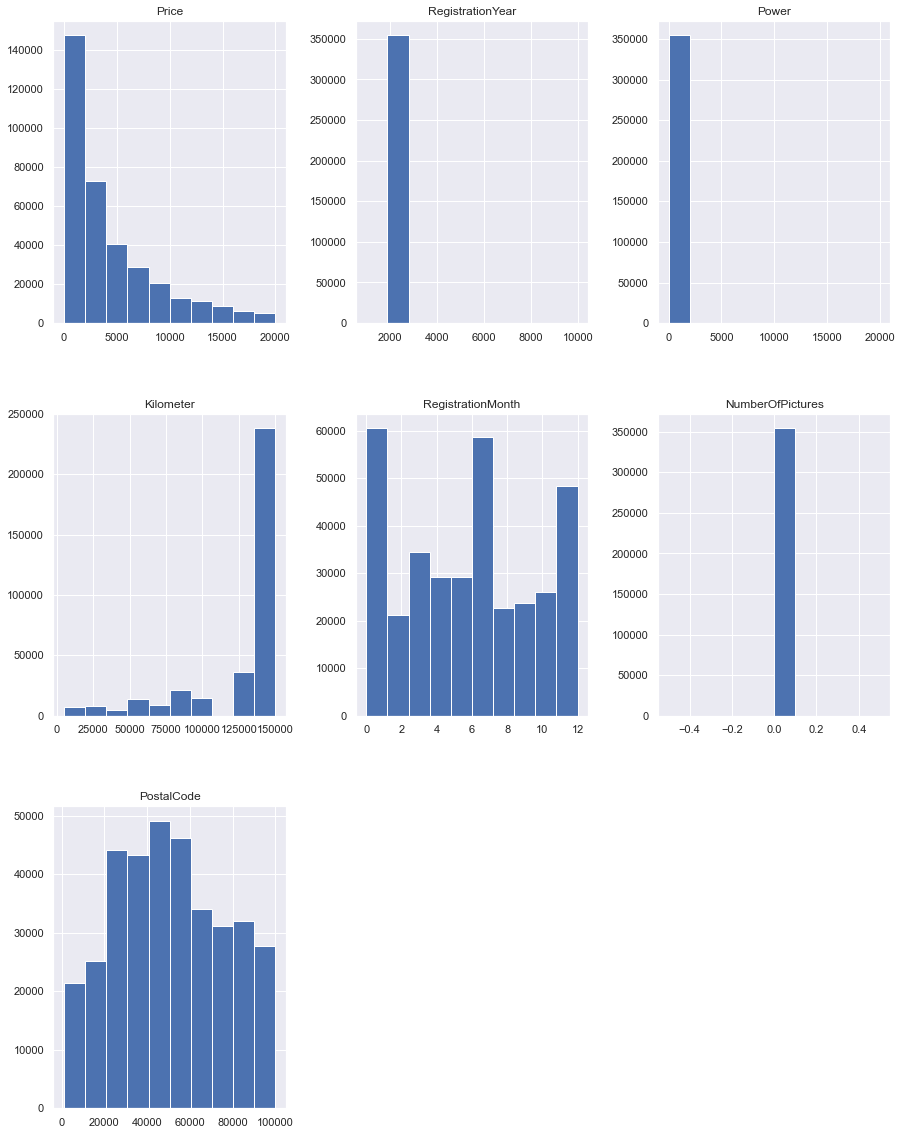

In [4]:
data = pd.read_csv('autos.csv')
start(data)

По первому взгляду мы обнаружили `4 дубликата`, много пропусков в разных колонках. Так же гистограммы показали нам некоторые особенности признаков. Например по столбцу киллометража видно, что большинство машин очень не новы, а с большим пробегом. Фотографий в объявлениях очень мало или нет вовсе, а в признаках о годе регистрации и мощности авто есть много выбросов. Так же в столбце цены много машин имеет очень маленькую стоимость или равна нулю. В дальнейшем обязательно обратим на это внимание.

И так, приступим. Для начала переименуем столбцы в привычный нам вид и приведём всё к нижнему регистру.

In [5]:
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data.head(3)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [6]:
data.columns = [re.sub(r'(?<=[a-z])(?=[A-Z0-9])|(?<=[A-Z0-9])(?=[A-Z][a-z\d])', '_', col).lower()
                for col in data.columns]
data.head(3)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Далее удалим из таблицы столбцы, которые *точно не понадобятся* нам для обучения моделей. (`date_crawled, registration_month, date_created, number_of_pictures, postal_code, last_seen`)

In [7]:
data = data.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures',\
                  'postal_code', 'last_seen'], axis=1)
data.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN


Удалили именно эти колонки так как от их показателей не зависит цена продаваемого авто. Например колонка с количеством фотографий. Стоимость не уменьшится если их не будет вовсе или не увеличится если их будет много. Так же и дата создания объявления или последний раз, когда продавец был на платформе. И так далее.

Первый взляд на данные показал, что есть `4 дубликата`. Посмотрим на их количество после удаления не нужных нам столбцов. Возможно появятся неявные дубликаты.

In [8]:
data[data.duplicated()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1117,950,small,1999,manual,60,polo,150000,petrol,volkswagen,no
1396,0,NaN,2000,NaN,0,NaN,150000,NaN,volvo,NaN
2169,0,coupe,2002,manual,129,c_klasse,150000,petrol,mercedes_benz,no
2833,1499,small,2001,manual,58,corsa,150000,petrol,opel,no
3025,2800,wagon,2005,NaN,0,touran,150000,gasoline,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354352,6500,sedan,2003,auto,145,e_klasse,150000,gasoline,mercedes_benz,no
354355,4400,sedan,2008,manual,105,leon,150000,gasoline,seat,no
354358,1490,small,1998,manual,50,lupo,150000,petrol,volkswagen,no
354359,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no


Да, действительно. Около 45040 дубликата. Удалим эти строки из таблицы.

In [9]:
data = data[~data.duplicated()]
data.shape[0]

309329

Теперь будем рассматривать каждый признак отдельно. При наличии аномальных значений будем от них избавляться и решим вопрос с имеющимися пропусками в некоторых столбцах.

Первый признак `price`. Посторим гистограмму и подберём для неё такие настройки отображения, чтобы она была максимально показательна.

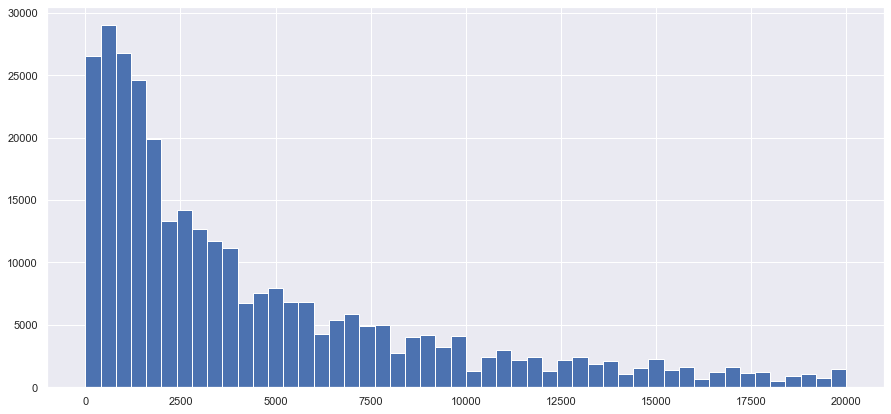

In [10]:
data['price'].hist(bins=50);

Видим достаточно плавное изменение цены. Без резких всплесков. Но видно и то, что цена начинается с `0`. Поменяем масштаб графика.

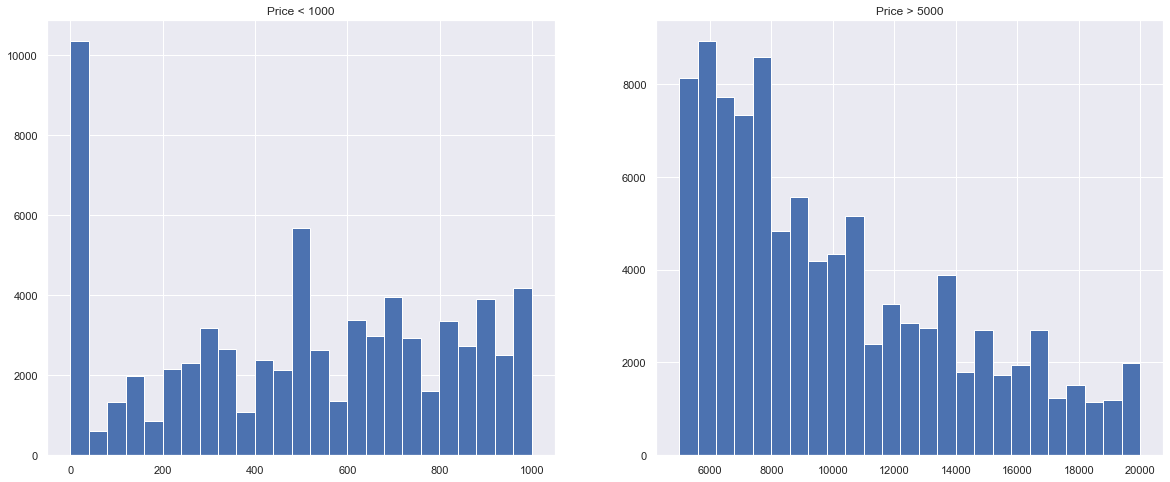

In [11]:
var1 = data.query('price < 1000')['price']
var2 = data.query('price > 5000')['price']

fig, ax = plt.subplots(1, 2, figsize = (20,8))
# fig.suptitle('Название', fontsize = 30, fontweight='bold')

ax[0].hist(var1, bins=25)
ax[0].set_title('Price < 1000')

ax[1].hist(var2, bins=25)
ax[1].set_title('Price > 5000')

plt.show()

Около `12000 продавцов` выставили `стоимость 0` или очень приближенную к `0`. Мы избавимся от этих данных, чтобы они не давали дополнительных искажений при обучении модели. Так же мы видим всплеск на `500`. Это популярная цена в данном диапазоне. Поэтому всё, что меньше `500` мы уберём из датасете. 

In [12]:
data = data.query('price >= 500')

Далее признак `vehicle_type`. Это тип автомобильного кузова. При первичном осмотре данных в этом столце мы наблюдали `37490 пропуск`. Заполнить категориальный признак в нашем случае мы не имеем возможности, но и удалять такое количество данных так же мы не будем. Просто заполним значением `"other"`. Но для начала посмтрим уникальные значение на предмет неявных дубликатов.

In [13]:
data['vehicle_type'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       nan, 'other'], dtype=object)

In [14]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')
data['vehicle_type'].isna().sum()

0

Отлично! Приступаем к признаку `registration_year`. Это год регистрации автомобиля. Пропусков нет, но посмотрим на уникальные значения столбца и построим график.

In [15]:
data['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1234, 1400, 1500, 1600, 1602, 1800, 1910, 1923,
       1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2066, 2290, 2500, 2800, 2900, 3000,
       3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5911,
       6000, 7000, 7100, 7800, 8200, 8500, 8888, 9000, 9450, 9999],
      dtype=int64)

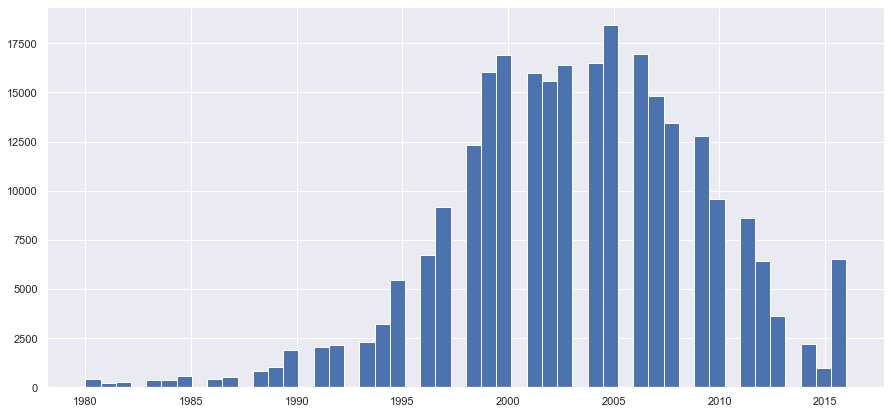

In [16]:
data.query('registration_year >= 1980 & registration_year <= 2016')['registration_year'].hist(bins=50);

У нас много разный выбросов в этом столбце. Постоив график из более "адекватных лет", мы принимаем решение оставить только годы регистрации `с 1990 по 2016`. Это именно тот год, когда выли выгружены объявления и сформирована таблица.

In [17]:
data = data.query('registration_year >= 1990 & registration_year <= 2016')

Далее `gearbox`. Это тип коробки передач. Так же проверим уникальные значения.

In [18]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Хорошо. Так как на начальном этапе в таблице было `19833` пропусков, то замени пустые значения `"unknown"`.

In [19]:
data['gearbox'] = data['gearbox'].fillna('unknown')
data['gearbox'].isna().sum()

0

Переходим к `power`. В этом столбце мощность авто (л. с.). Построим график, но уже масштаб будет брать такой, чтобы было понятно, так как при первоначальном ознакомлении с данными на графике было видно, что есть значительные аномалии.



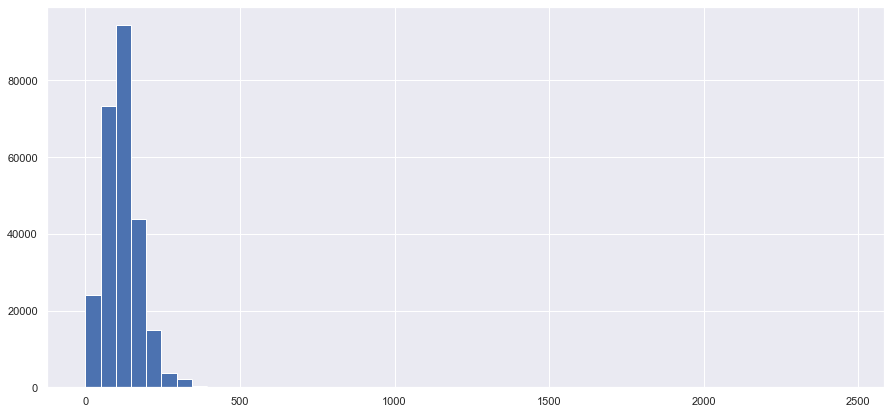

In [20]:
data.query('power < 2500')['power'].hist(bins=50);

И ещё увеличим масштаб, чтобы было видно, что происходит в районе `0`.

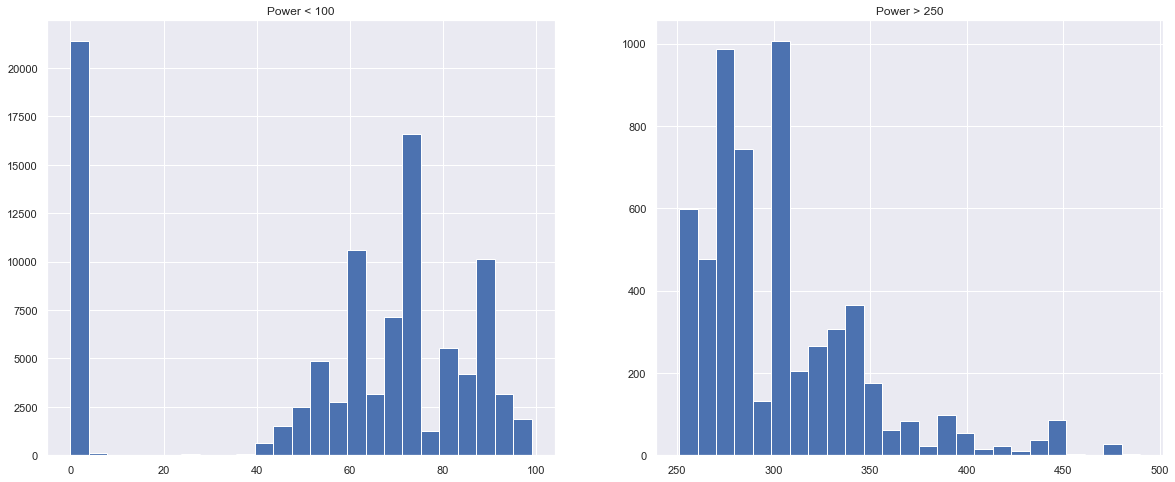

In [21]:
var1 = data.query('power < 100')['power']
var2 = data.query('power > 250 & power < 500')['power']

fig, ax = plt.subplots(1, 2, figsize = (20,8))
# fig.suptitle('Название', fontsize = 30, fontweight='bold')

ax[0].hist(var1, bins=25)
ax[0].set_title('Power < 100')

ax[1].hist(var2, bins=25)
ax[1].set_title('Power > 250')

plt.show()

Отлично! Теперь прекрасно видно. Очень много авто с мощностью 0. Заполним их медианой по бренду. 

In [22]:
data.loc[(data['power'] == 0), 'power'] = data.groupby('brand')['power'].median()
data[data['power'] == 0]['power'].count()

0

Хорошо. Оставим в датафрейме только те машины, которые укладываются по мощности в диапазон `от 30 до 450`.

In [23]:
data = data.loc[(data['power'] <= 450)]

Далее `model`. Это модель автомобиля. Как обычно посмотрим уникальные отсортированные значения, на поиск неявных дубликатов. И заполним пропуски на значение `"other"`. (в начале было замечено `19705` в столбце)

In [24]:
data['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [25]:
data['model'] = data['model'].fillna('other')
data['model'].isna().sum()

0

Столбец `kilometer`. Это данные о пробеге (км). Пока первый признак в котором ничего не будем менять. Очень много машин, которые имеют пробег около `150000 км`. Но есть и те, которые не так много колесили по дорогам. Поэтому переходим к следующему столбцу.

Это `fuel_type` - тип топлива. Смотрим уникальные значение и заполним `32895` пропуска, которые были на начальном этапе.

In [26]:
data['fuel_type'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

In [27]:
data['fuel_type'] = data['fuel_type'].fillna('other')
data['fuel_type'].isna().sum()

0

Далее `brand`. Это марка автомобиля. Пропусков нет, но посмотрим на уникальные отосортированые значения.

In [28]:
data['brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Отлично. Далее `repaired`. Это была машина в ремонте или нет? Очень много пропусков. Аж `71154` на начальном этапе.Удалить строки не можем, так как столбец важен для нас. Посмотрим сколько проехали авто, которые точно было в ремонте.

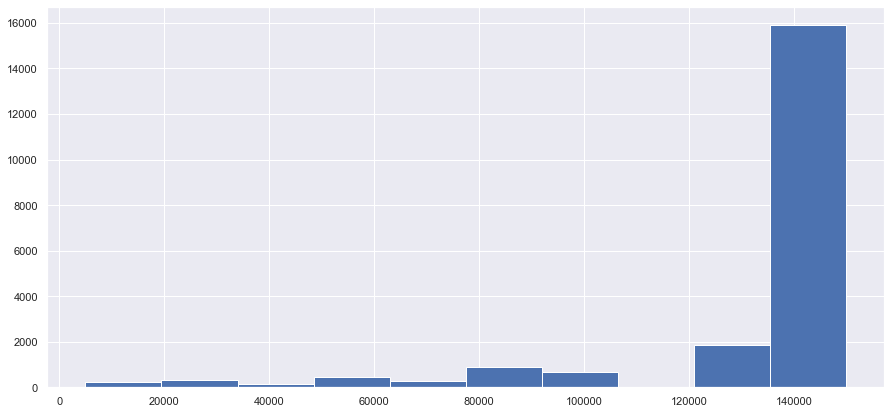

In [29]:
data.query('repaired == "yes"')['kilometer'].hist();

По графику видно, что в основном те машины, что проехали больше 120000 киллометров, были в ремонте. Так и заполним пустые значения.

In [30]:
data.loc[data['kilometer'] >= 120000, 'repaired'] = 'yes'
data.loc[data['kilometer'] < 120000, 'repaired'] = 'no'
data['repaired'].isna().sum()

0

Обработали все признаки. Проверим на пропуски повторно наш датасет и посмотрим на его общее состояние.

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235462 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              235462 non-null  int64  
 1   vehicle_type       235462 non-null  object 
 2   registration_year  235462 non-null  int64  
 3   gearbox            235462 non-null  object 
 4   power              235462 non-null  float64
 5   model              235462 non-null  object 
 6   kilometer          235462 non-null  int64  
 7   fuel_type          235462 non-null  object 
 8   brand              235462 non-null  object 
 9   repaired           235462 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 19.8+ MB


In [32]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Пропусков нет. Оставшихся данных вполне должно хватить для нашей задачи, с учётом того, что это уже подготовленные данные. Построим схему корреляции и посмотрим, вдруг у нас в признаках есть очень зависимые пары в количественных данных.

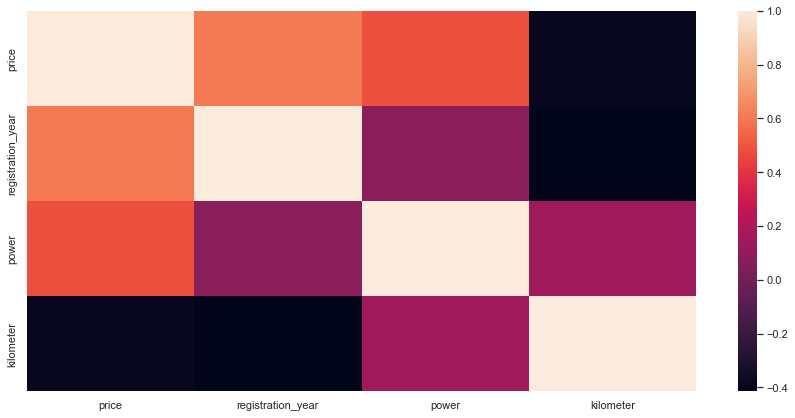

In [33]:
sns.heatmap(data.corr());

Таких нет.

Следующим этапом будет разбиение таблицы на обучающую, валидационную и тестовые выборки. `(60|20|20)`

In [34]:
features = data.drop('price', axis=1)
target = data['price']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=123456)

print(features_train.shape[0])
print(features_valid.shape[0])
print(target_test.shape[0])

141277
47093
47092


Взглянем одним глазком на обучающую выборку. У нас есть `6` категориальных признаков. И так как мы будем обучать разные модели, то для некоторых из них нужно закодировать категориальные признаки как однократный числовой массив. Используем `OneHotEncoder` для линейной модели. А для "дерева" будет использовать порядковое кодирование `OrdinalEncoder` (это позволит увеличить скорость обучения).

Для начала скопируем выборки, чтобы не менять исходные.

In [35]:
features_train_OHE = features_train.copy()
features_valid_OHE = features_valid.copy()
features_test_OHE = features_test.copy()

features_train_OE = features_train.copy()
features_valid_OE = features_valid.copy()
features_test_OE = features_test.copy()

In [36]:
features_train.sample(3)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
298937,sedan,2003,manual,113.0,megane,150000,petrol,renault,yes
90682,coupe,2001,manual,147.0,astra,150000,petrol,opel,yes
180874,sedan,1999,manual,150.0,bora,150000,petrol,volkswagen,yes


Подготовим модель для кодирования данных в `OneHotEncoder` и закодируем данные.

In [37]:
ohe_features_ridge = features_train_OHE.select_dtypes(include='object').columns.to_list()

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train_OHE[ohe_features_ridge])

features_train_OHE[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_OHE[ohe_features_ridge])
features_train_OHE = features_train_OHE.drop(ohe_features_ridge, axis=1)

features_valid_OHE[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid_OHE[ohe_features_ridge])
features_valid_OHE = features_valid_OHE.drop(ohe_features_ridge, axis=1)

features_test_OHE[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test_OHE[ohe_features_ridge])
features_test_OHE = features_test_OHE.drop(ohe_features_ridge, axis=1)

In [38]:
features_train_OHE.sample(3)

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes
155937,1991,54.0,125000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
46190,1999,58.0,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
59700,2003,101.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Подготовим модель для кодирования данных в `OrdinalEncoder` и закодируем данные.

In [39]:
OE_features_ridge = features_train_OE.select_dtypes(include='object').columns.to_list()

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(data[OE_features_ridge])

features_train_OE[OE_features_ridge] = enc.transform(features_train_OE[OE_features_ridge])
features_valid_OE[OE_features_ridge] = enc.transform(features_valid_OE[OE_features_ridge])
features_test_OE[OE_features_ridge] = enc.transform(features_test_OE[OE_features_ridge])

In [40]:
features_train_OE.sample(3)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
287444,2.0,1997,1.0,90.0,215.0,150000,6.0,24.0,1.0
24819,7.0,2001,1.0,136.0,103.0,150000,4.0,10.0,1.0
189284,0.0,2008,1.0,102.0,221.0,150000,2.0,38.0,1.0


Теперь нам нужно стандартизировать данные для использования их линейной модели. Сделаем это при помощи `StandardScaler`.

In [41]:
pd.options.mode.chained_assignment = None
numeric = features_train_OHE.select_dtypes(include='number').columns.to_list()

scaler = StandardScaler()
scaler.fit(features_train_OHE[numeric])

features_train_OHE[numeric] = scaler.transform(features_train_OHE[numeric])
features_valid_OHE[numeric] = scaler.transform(features_valid_OHE[numeric])
features_test_OHE[numeric] = scaler.transform(features_test_OHE[numeric])

In [42]:
features_test_OHE.sample(3)

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes
218698,-1.054633,0.483610,0.618392,-0.267634,-0.227101,-0.210254,-0.621163,-0.529914,-0.20335,1.955769,...,-0.138367,-0.13196,-0.070717,-0.048092,-0.084687,-0.124927,-0.011598,-0.506877,-0.100332,0.568389
151741,-0.686539,-0.343417,0.618392,-0.267634,-0.227101,-0.210254,-0.621163,-0.529914,-0.20335,-0.511308,...,-0.138367,-0.13196,-0.070717,-0.048092,-0.084687,-0.124927,-0.011598,-0.506877,-0.100332,0.568389
96869,-1.606774,-0.174253,0.618392,-0.267634,-0.227101,-0.210254,1.609884,-0.529914,-0.20335,-0.511308,...,-0.138367,-0.13196,-0.070717,-0.048092,-0.084687,-0.124927,-0.011598,-0.506877,-0.100332,0.568389


**Вывод:** В начале работы мы познакомились с данными. И провели предобработку, прежде чем обучать модели. Что именно было сделано:
- переименовали столбцы в привычный нам вид и привели всё к нижнему регистру;
- удалили из таблицы столбцы, которые *точно не понадобятся* нам для обучения моделей. (`date_crawled, registration_month, date_created, number_of_pictures, postal_code, last_seen`);
- было найдены `45040` дубликата и удалены и таблицы;
- в столбце `price` около `12000` продавцов выставили стоимость `0` или очень приближенную к `0`. Поэтому всё, что меньше `500` евро мы убрали из датасете, чтобы они не давали дополнительных искажений при обучении моделей;
- в признаке `vehicle_type` (тип автомобильного кузова) при первичном осмотре данных в этом столбце мы наблюдали `37490 пропуск`. Заполнить категориальный признак в нашем случае мы не имели возможности, но и удалять такое количество данных так же мы не стали. Просто заполнили значением `"other"`;
- по таму же принципу заполнили пропуски значением `"other"` в столбцах `model, fuel_type`. `gearbox` - в этом столбце пропуски заменили на `"unknown"`; 
- а в признаке по ремонту (`repaired`), заменили пропуски у всех машин, что имеют пробег более `120000` на `"yes"`, у другихх на `"no"` соответственно;
- в признаке `registration_year`. Это год регистрации автомобиля. Пропусков не было, но мы заметили разные выбросы в этом столбце. Постоив график, мы приняли решение оставить только годы регистрации `с 1990 по 2016` так как последний год это год выгрузки объявления и создания таблицы;
- `power`. В этом столбце мощность авто (л. с.) мы оставили в датафрейме только те машины, которые укладываются по мощности в диапазон `от 40 до 450`. Были значения и в райне `0`  мы из заменили на медиану по брендам;
- далее мы разбили таблицу на обучающую, валидационную и тестовые выборки. `(60|20|20)`
- у нас `6` категориальных признаков. И так как мы будем обучать разные модели, то для некоторых из них нужно закодировать категориальные признаки как однократный числовой массив. Используем `OneHotEncoder` для линейной модели. А для моеделей решающего дерева будем использовать порядковое кодирование `OrdinalEncoder` (это позволит увеличить скорость обучения).
- после кодирования мы стандартизировали данные для использования их линейной моделью. Сделали это при помощи `StandardScaler`.

## Обучение моделей

Обучим модели и найдём лучшие гиперпараметры для них. Первой моделью будет линейная, а именно `LinearRegression`.

In [43]:
%%time

model_LR = LinearRegression().fit(features_train_OHE, target_train)

predictions_valid = model_LR.predict(features_valid_OHE)

best_score_train_LR = round(mean_squared_error(target_valid, predictions_valid)**0.5)
print('RMSE модели:', best_score_train_LR)

RMSE модели: 2384
Wall time: 3.11 s


Вторая модель будет древовидного типа, а именно `DecisionTreeRegressor`.

In [44]:
%%time 
model_DTR = DecisionTreeRegressor(random_state=RD_ST)

param_grid = {'max_depth': range (2, 20, 2)}

grid = GridSearchCV(model_DTR, param_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid.fit(features_train_OE, target_train)

best_param_train_DTR = grid.best_params_
best_score_train_DTR = round(grid.best_score_ * -1)

print('Параметры лучшей модели:', best_param_train_DTR)
print('RMSE лучшей модели:', best_score_train_DTR)

Параметры лучшей модели: {'max_depth': 12}
RMSE лучшей модели: 1886
Wall time: 4.89 s


И теперь модель с бустингом. `LightGBM`.

In [45]:
%%time 
model_LGB = lightgbm.LGBMRegressor(random_state=RD_ST)

param_grid = {'n_estimators': range (50, 500, 50),
              'num_leaves': range (20, 200, 20)}

grid = GridSearchCV(model_LGB, param_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid.fit(features_train_OE, target_train)

best_param_train_LGB = grid.best_params_
best_score_train_LGB = round(grid.best_score_ * -1)

print('Параметры лучшей модели:', best_param_train_LGB)
print('RMSE лучшей модели:', best_score_train_LGB)

Параметры лучшей модели: {'n_estimators': 450, 'num_leaves': 120}
RMSE лучшей модели: 1569
Wall time: 4min 56s


**Вывод:** Мы обучили `3 разные модели` и нашли лучшие гиперпараметры для них.

1 модель `LinearRegression` (RMSE модели: `{{best_score_train_LR}}`)

2 модель `DecisionTreeRegressor` (RMSE модели: `{{best_score_train_DTR}}`) 
- Параметры лучшей модели: {{best_param_train_DTR}}

3 модель `LightGBM` (RMSE модели: `{{best_score_train_LGB}}`) 
- Параметры лучшей модели: {{best_param_train_LGB}}

## Анализ моделей

Теперь имея параметры для моделей обучим их заново, замерим скорость обучения и скорость предсказаний, а так же качество предсказаний.

Первая `LinearRegression`

In [46]:
%%time
model_LR = LinearRegression()
model_LR.fit(features_train_OHE, target_train)

Wall time: 4.38 s


LinearRegression()

In [47]:
%%time
predictions_valid = model_LR.predict(features_valid_OHE)

Wall time: 20.9 ms


In [48]:
RMSE_valid_LR = round(mean_squared_error(target_valid, predictions_valid)**0.5)
print('RMSE модели:', RMSE_valid_LR)

RMSE модели: 2384


Вторая `DecisionTreeRegressor`

In [49]:
%%time
model_DTR = DecisionTreeRegressor(**best_param_train_DTR, random_state=RD_ST)
model_DTR.fit(features_train_OE, target_train)

Wall time: 291 ms


DecisionTreeRegressor(max_depth=12, random_state=12345)

In [50]:
%%time
predictions_valid = model_DTR.predict(features_valid_OE)

Wall time: 15 ms


In [51]:
RMSE_valid_DTR = round(mean_squared_error(target_valid, predictions_valid)**0.5)
print('RMSE модели:', RMSE_valid_DTR)

RMSE модели: 1867


Третья модель `LightGBM`.

In [58]:
%%time
model_LGB = lightgbm.LGBMRegressor(**best_param_train_LGB, random_state=RD_ST)
model_LGB.fit(features_train_OE, target_train)

Wall time: 2.12 s


LGBMRegressor(n_estimators=450, num_leaves=120, random_state=12345)

In [53]:
%%time
predictions_valid = model_LGB.predict(features_valid_OE)

Wall time: 704 ms


In [54]:
RMSE_valid_LGB = round(mean_squared_error(target_valid, predictions_valid)**0.5)
print('RMSE модели:', RMSE_valid_LGB)

RMSE модели: 1569


Составим таблицы для наглядности результатов.

In [55]:
tabledata = [["LinearRegression", "~3.2 s", "~21.4 ms", RMSE_valid_LR],
             ["DecisionTreeRegressor", "~330 ms", "~14 ms", RMSE_valid_DTR],
             ["LightGBM", "~3.53 s", "~658 ms", RMSE_valid_LGB]]
df= pd.DataFrame(tabledata, columns=["Model", "Wall time_train", "Wall time_predict", "RMSE_valid"])
df

,Model,Wall time_train,Wall time_predict,RMSE_valid
0,LinearRegression,~3.2 s,~21.4 ms,2384
1,DecisionTreeRegressor,~330 ms,~14 ms,1867
2,LightGBM,~3.53 s,~658 ms,1569


Проверка модели на тестовой выборке.

In [56]:
predictions_valid = model_DTR.predict(features_test_OE)
result = round(mean_squared_error(target_test, predictions_valid)**0.5)
print('RMSE модели:', result)

RMSE модели: 1857


**Вывод:** Имея лучшие гиперпараметры, мы обучили модели заново, замерив скорость обучения и скорость предсказаний, а так же качество этих предсказаний. В табличе можете наблюдать результаты. Что касается того, какую модель выбрать, то это `DecisionTreeRegressor`. Если для заказчика важны все три параметра, а заданием была модель, которая выдаёт результат `RMSE менее 2500` то результат очевиден. Результат на тестовой выборке `RMSE = {{result}}`.

## Общий вывод

**Вывод:** В начале работы мы познакомились с данными. И провели предобработку, прежде чем обучать модели. Что именно было сделано:
- переименовали столбцы в привычный нам вид и привели всё к нижнему регистру;
- удалили из таблицы столбцы, которые *точно не понадобятся* нам для обучения моделей. (`date_crawled, registration_month, date_created, number_of_pictures, postal_code, last_seen`);
- было найдены `45040` дубликата и удалены и таблицы;
- в столбце `price` около `12000` продавцов выставили стоимость `0` или очень приближенную к `0`. Поэтому всё, что меньше `500` евро мы убрали из датасете, чтобы они не давали дополнительных искажений при обучении моделей;
- в признаке `vehicle_type` (тип автомобильного кузова) при первичном осмотре данных в этом столбце мы наблюдали `37490 пропуск`. Заполнить категориальный признак в нашем случае мы не имели возможности, но и удалять такое количество данных так же мы не стали. Просто заполнили значением `"other"`;
- по таму же принципу заполнили пропуски значением `"other"` в столбцах `model, fuel_type`. `gearbox` - в этом столбце пропуски заменили на `"unknown"`; 
- а в признаке по ремонту (`repaired`), заменили пропуски у всех машин, что имеют пробег более `120000` на `"yes"`, у другихх на `"no"` соответственно;
- в признаке `registration_year`. Это год регистрации автомобиля. Пропусков не было, но мы заметили разные выбросы в этом столбце. Постоив график, мы приняли решение оставить только годы регистрации `с 1990 по 2016` так как последний год это год выгрузки объявления и создания таблицы;
- `power`. В этом столбце мощность авто (л. с.) мы оставили в датафрейме только те машины, которые укладываются по мощности в диапазон `от 40 до 450`. Были значения и в райне `0`  мы из заменили на медиану по брендам;
- далее мы разбили таблицу на обучающую, валидационную и тестовые выборки. `(60|20|20)`
- у нас `6` категориальных признаков. И так как мы будем обучать разные модели, то для некоторых из них нужно закодировать категориальные признаки как однократный числовой массив. Используем `OneHotEncoder` для линейной модели. А для моеделей решающего дерева будем использовать порядковое кодирование `OrdinalEncoder` (это позволит увеличить скорость обучения).
- после кодирования мы стандартизировали данные для использования их линейной моделью. Сделали это при помощи `StandardScaler`.

Далее мы обучили `3 разные модели` и нашли лучшие гиперпараметры для них.

1 модель `LinearRegression` (RMSE модели: `{{best_score_train_LR}}`)

2 модель `DecisionTreeRegressor` (RMSE модели: `{{best_score_train_DTR}}`) 
- Параметры лучшей модели: {{best_param_train_DTR}}

3 модель `LightGBM` (RMSE модели: `{{best_score_train_LGB}}`) 
- Параметры лучшей модели: {{best_param_train_LGB}}

И уже в конце имея лучшие гиперпараметры, мы обучили модели заново, замерив скорость обучения и скорость предсказаний, а так же качество этих предсказаний. В табличе можете наблюдать результаты. Что касается того, какую модель выбрать, то это `DecisionTreeRegressor`. Если для заказчика важны все три параметра, а заданием была модель, которая выдаёт результат `RMSE менее 2500` и быстрая, то результат очевиден. Результат на тестовой выборке `RMSE = {{result}}`.

In [57]:
tabledata = [["LinearRegression", "~3.2 s", "~21.4 ms", RMSE_valid_LR],
             ["DecisionTreeRegressor", "~330 ms", "~14 ms", RMSE_valid_DTR],
             ["LightGBM", "~3.53 s", "~658 ms", RMSE_valid_LGB]]
df= pd.DataFrame(tabledata, columns=["Model", "Wall time_train", "Wall time_predict", "RMSE_valid"])
df

,Model,Wall time_train,Wall time_predict,RMSE_valid
0,LinearRegression,~3.2 s,~21.4 ms,2384
1,DecisionTreeRegressor,~330 ms,~14 ms,1867
2,LightGBM,~3.53 s,~658 ms,1569
